# Congressional Record and Hansard Analysis


This notebook contains the analysis of the Congressional Record and Hansard datasets.


## Setup


In [122]:
import ssl
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import umap

CONGRESSIONAL_RECORD_PATH = '../congressional-record/dist/'
HANSARD_PATH = '../hansard-in-full/'
CLIMATE_DICTIONARY_PATH = 'dictionaries/dist/'
CONGRESSIONAL_RECORD_PROCEDURAL_TERMS_PATH = 'dictionaries/dist/'
HANSARD_PROCEDURAL_TERMS_PATH = 'dictionaries/dist/'

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

# Ignore SSL certificate errors
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('punkt')
nltk.download('stopwords')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing


### Preprocessing functions for the Congressional Record and Hansard


In [123]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


def corpus_preprocessing(corpus: pd.DataFrame, text_column_name: str, year_range: tuple, year_column_name: str = 'year'):
    corpus = corpus.copy()
    # Remove corpus content from outside the year range
    corpus = corpus[corpus[year_column_name].between(
        year_range[0], year_range[1])]
    # Clean, tokenize, and stem the corpus
    corpus['cleaned_stems'] = corpus[text_column_name].apply(tokenize_and_stem)
    # Remove any documents with fewer than 10 stems
    corpus['stem_count'] = corpus['cleaned_stems'].apply(
        lambda x: len(x.split()))
    corpus = corpus[corpus['stem_count'] >= 10]
    return corpus


def tokenize_and_stem(text):
    # Text should almost always be a string, but we check just in case
    if not isinstance(text, str):
        text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and symbols
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stem the tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Rejoin the stemmed tokens
    joined_stems = ' '.join(stemmed_tokens)
    return joined_stems

### Congressional Record preprocessing


**Loading the Congressional Record**


In [124]:
congressional_record = pd.read_csv(
    CONGRESSIONAL_RECORD_PATH + 'congressional_record.csv')

**Preprocessing the Congressional Record**


In [125]:
congressional_record['date'] = pd.to_datetime(
    congressional_record['date'], format='%Y%m%d')
congressional_record['year'] = congressional_record['date'].dt.year

congressional_record = corpus_preprocessing(
    congressional_record, 'speech', (2008, 2009))

### Hansard preprocessing


**Loading Hansard**


In [126]:
hansard = pd.read_csv(HANSARD_PATH + 'hansard_with_mp_details.csv')

**Preprocessing Hansard**


In [127]:
hansard['speech_date'] = pd.to_datetime(hansard['speech_date'])
hansard['year'] = hansard['speech_date'].dt.year

hansard = corpus_preprocessing(hansard, 'text', (2008, 2009))

## Filtering


### Filtering functions for the Congressional Record and Hansard


In [128]:
climate_stems = pd.read_csv(
    CLIMATE_DICTIONARY_PATH + 'climate_stems.csv')
climate_stems = set(climate_stems['stem'].tolist())

congressional_record_procedural_stems = pd.read_csv(
    CONGRESSIONAL_RECORD_PROCEDURAL_TERMS_PATH + 'shortened_congressional_record_procedural_stems.csv')
congressional_record_procedural_stems = set(
    congressional_record_procedural_stems['stem'].tolist())

hansard_procedural_stems = pd.read_csv(
    HANSARD_PROCEDURAL_TERMS_PATH + 'shortened_hansard_procedural_stems.csv')
hansard_procedural_stems = set(hansard_procedural_stems['stem'].tolist())


def term_proportion(doc, terms):
    doc_tokens = set(doc.split())
    term_count = sum(
        term in doc_tokens for term in terms)
    total_terms = len(doc_tokens)

    if total_terms == 0:
        return 0
    return term_count / total_terms


def remove_terms(doc, terms):
    doc_tokens = doc.split()
    return ' '.join([word for word in doc_tokens if word not in terms])


def climate_filter(corpus_df, procedural_stems, climate_stems=climate_stems):
    corpus_df = corpus_df.copy()
    # Remove documents that contain more than 50% procedural terms
    corpus_df['procedural_proportion'] = corpus_df['cleaned_stems'].apply(
        lambda doc: term_proportion(doc, procedural_stems))
    corpus_df = corpus_df[corpus_df['procedural_proportion'] < 0.5]
    # Remove all procedural terms from the remaining documents
    corpus_df['cleaned_stems'] = corpus_df['cleaned_stems'].apply(
        lambda doc: remove_terms(doc, procedural_stems))
    # Extract documents that contain at least 20% climate terms
    corpus_df['climate_proportion'] = corpus_df['cleaned_stems'].apply(
        lambda doc: term_proportion(doc, climate_stems))
    corpus_df = corpus_df[corpus_df['climate_proportion'] >= 0.2]
    return corpus_df

### Extracting documents that discuss climate change from the Congressional Record


In [129]:
climate_congressional_record = climate_filter(
    congressional_record, congressional_record_procedural_stems)
climate_congressional_record = climate_congressional_record.sort_values(
    'climate_proportion', ascending=False)

climate_congressional_record.to_csv(
    DATA_PATH + 'climate_congressional_record.csv', index=False)

### Extracting documents that discuss climate change from Hansard


In [130]:
climate_hansard = climate_filter(hansard, hansard_procedural_stems)
climate_hansard = climate_hansard.sort_values(
    'climate_proportion', ascending=False)

climate_hansard.to_csv(DATA_PATH + 'climate_hansard.csv', index=False)

## Word cloud analysis


Word clouds are used to get a basic understanding of the most frequently used stems in the Congressional Record and Hansard.


In [131]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')


def get_sorted_word_scores(speeches):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(speeches)
    tfidf_scores = X.sum(axis=0).A1
    word_scores = zip(vectorizer.get_feature_names_out(), tfidf_scores)
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    return sorted_word_scores

### Calculating the Democratic and Republican TF-IDF scores for the cleaned tokens in the Congressional Record


In [132]:
democrat_speeches = climate_congressional_record[climate_congressional_record['party']
                                                 == 'D']['cleaned_stems']
republican_speeches = climate_congressional_record[climate_congressional_record['party']
                                                   == 'R']['cleaned_stems']

democrat_word_scores = get_sorted_word_scores(democrat_speeches)
republican_word_scores = get_sorted_word_scores(republican_speeches)

### Calculating the Labour and Conservative TF-IDF scores for the cleaned tokens in Hansard


In [133]:
labour_speeches = climate_hansard[climate_hansard['speech_party']
                                  == 'Labour']['cleaned_stems']
conservative_speeches = climate_hansard[climate_hansard['speech_party']
                                        == 'Conservative']['cleaned_stems']

labour_word_scores = get_sorted_word_scores(labour_speeches)
conservative_word_scores = get_sorted_word_scores(conservative_speeches)

### Calculating TF-IDF scores for the cleaned tokens in the Congressional Record and Hansard


In [134]:
congressional_record_speeches = climate_congressional_record['cleaned_stems']
hansard_speeches = climate_hansard['cleaned_stems']

congressional_record_word_scores = get_sorted_word_scores(
    congressional_record_speeches)
hansard_word_scores = get_sorted_word_scores(hansard_speeches)

### Word cloud visualisation


**Democratic and Republican TF-IDF score word clouds**


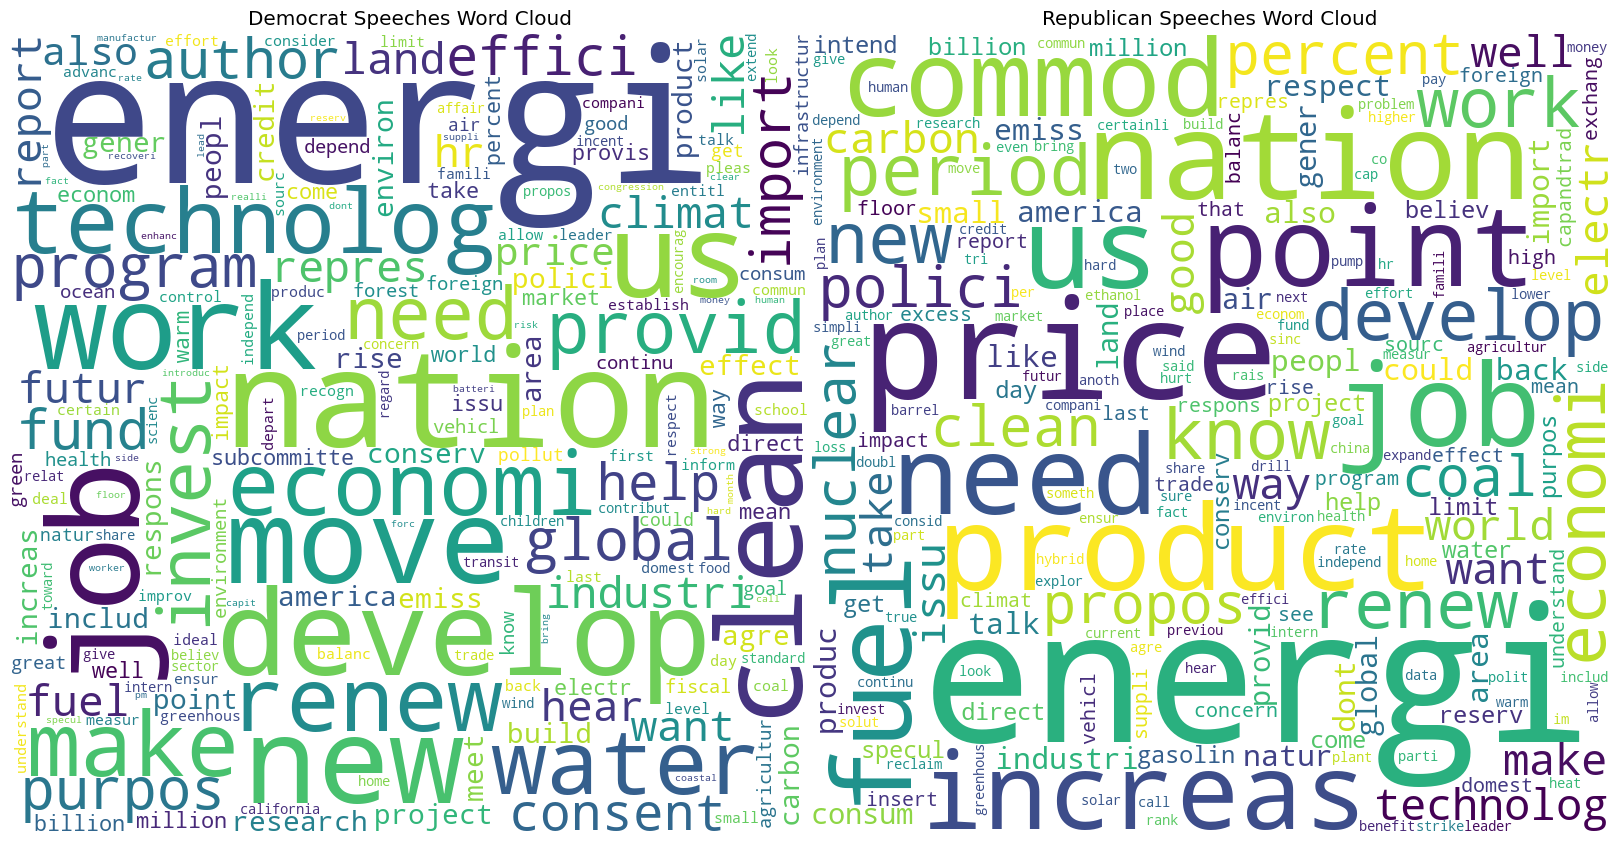

In [135]:
wordcloud_dem = WordCloud(width=800, height=800, background_color='white')
wordcloud_dem.generate_from_frequencies(dict(democrat_word_scores))

wordcloud_rep = WordCloud(width=800, height=800, background_color='white')
wordcloud_rep.generate_from_frequencies(dict(republican_word_scores))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_dem, interpolation='bilinear')
plt.title('Democrat Speeches Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_rep, interpolation='bilinear')
plt.title('Republican Speeches Word Cloud')
plt.axis("off")

plt.tight_layout(pad=0)
plt.show()

**Labour and Conservative TF-IDF score word clouds**


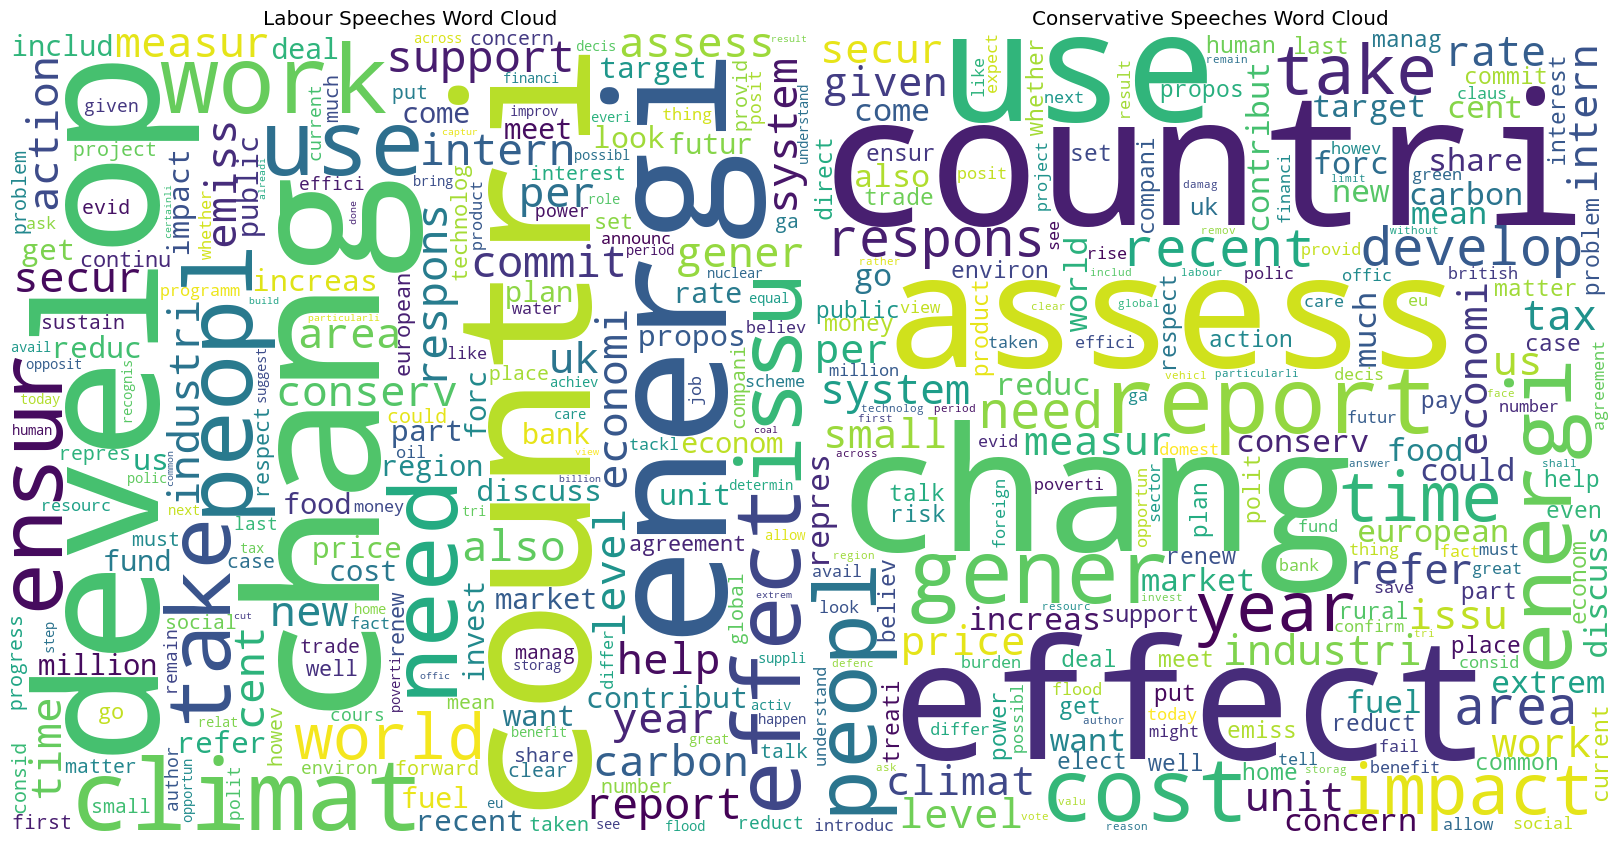

In [136]:
wordcloud_lab = WordCloud(width=800, height=800, background_color='white')
wordcloud_lab.generate_from_frequencies(dict(labour_word_scores))

wordcloud_con = WordCloud(width=800, height=800, background_color='white')
wordcloud_con.generate_from_frequencies(dict(conservative_word_scores))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_lab, interpolation='bilinear')
plt.title('Labour Speeches Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_con, interpolation='bilinear')
plt.title('Conservative Speeches Word Cloud')
plt.axis("off")

plt.tight_layout(pad=0)
plt.show()

**Congressional Record and Hansard TF-IDF score word clouds**


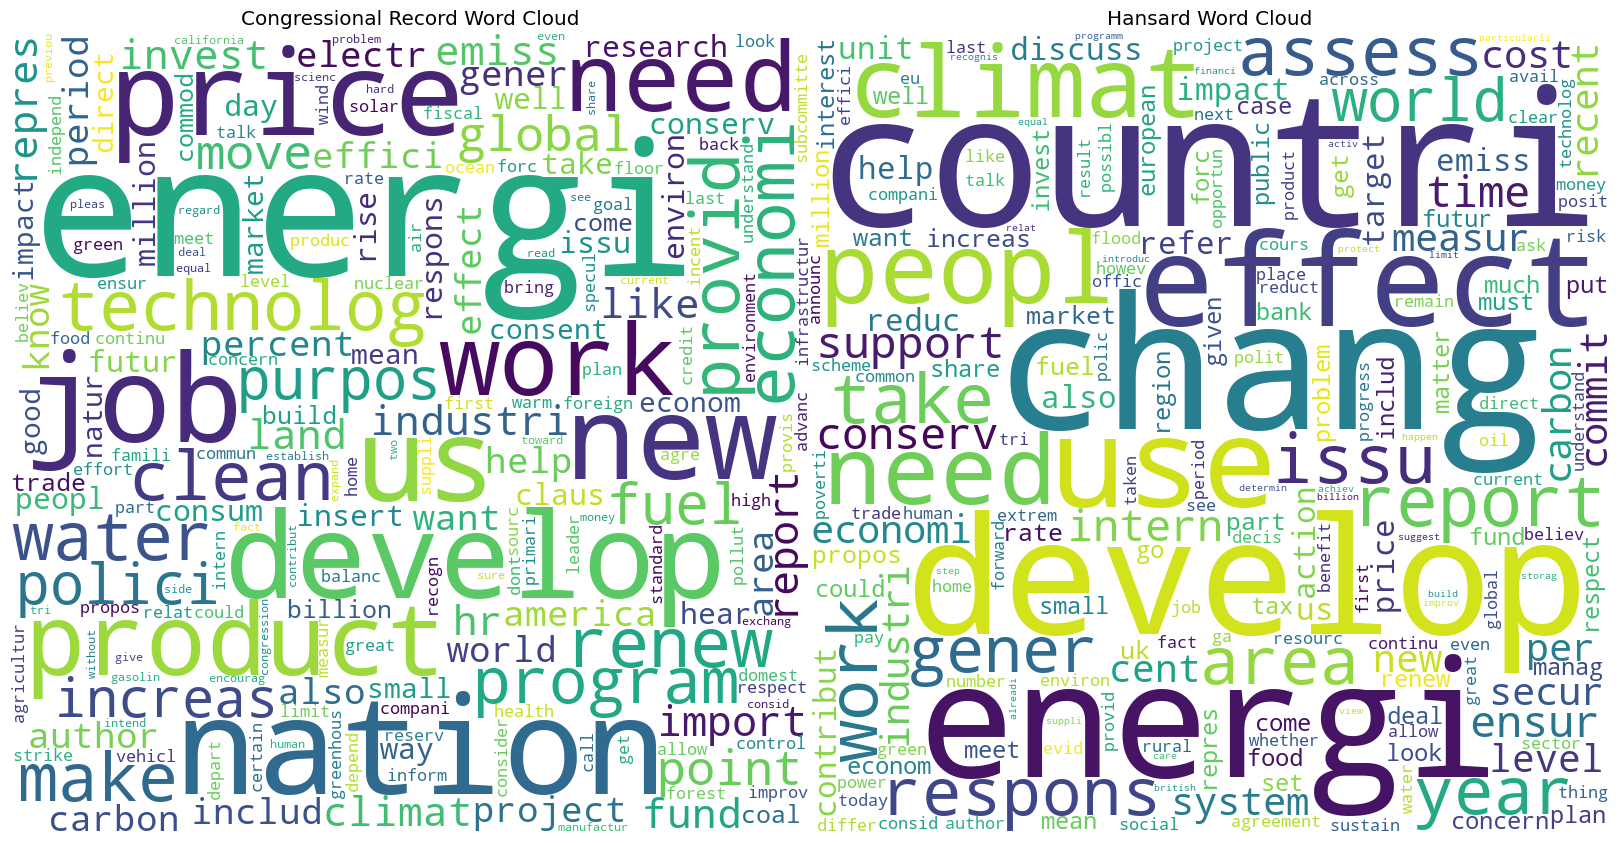

In [137]:
wordcloud_congressional = WordCloud(
    width=800, height=800, background_color='white')
wordcloud_congressional.generate_from_frequencies(
    dict(congressional_record_word_scores))

wordcloud_hansard = WordCloud(width=800, height=800, background_color='white')
wordcloud_hansard.generate_from_frequencies(dict(hansard_word_scores))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_congressional, interpolation='bilinear')
plt.title('Congressional Record Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_hansard, interpolation='bilinear')
plt.title('Hansard Word Cloud')
plt.axis("off")

plt.tight_layout(pad=0)
plt.show()

## Embeddings analysis


Word embeddings are used to investigate the first two hypotheses:

- Hypothesis 1: Labour and Conservative politicians should not exhibit a semantic distinction in the language they use to discuss climate change.
- Hypothesis 2: Democratic and Republican politicians should exhibit a widening semantic distinction in the language they use to discuss climate change.


In [138]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

### Embedding the climate filtered Congressional Record dataset


In [139]:
cleaned_stems = climate_congressional_record['cleaned_stems'].tolist()

climate_congressional_record_embeddings = model.encode(
    cleaned_stems, show_progress_bar=True)
np.save(DATA_PATH + 'climate_congressional_record_embeddings.npy',
        climate_congressional_record_embeddings)

Batches: 100%|██████████| 47/47 [00:09<00:00,  5.12it/s]


### Embedding the climate filtered Hansard dataset


In [140]:
cleaned_stems = climate_hansard['cleaned_stems'].tolist()

climate_hansard_embeddings = model.encode(
    cleaned_stems, show_progress_bar=True)
np.save(DATA_PATH + 'climate_hansard_embeddings.npy',
        climate_hansard_embeddings)

Batches: 100%|██████████| 237/237 [00:14<00:00, 16.80it/s]


### Visualizing the embeddings using UMAP


In [141]:
np.random.seed(42)
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')

**Visualising the US embeddings by party**


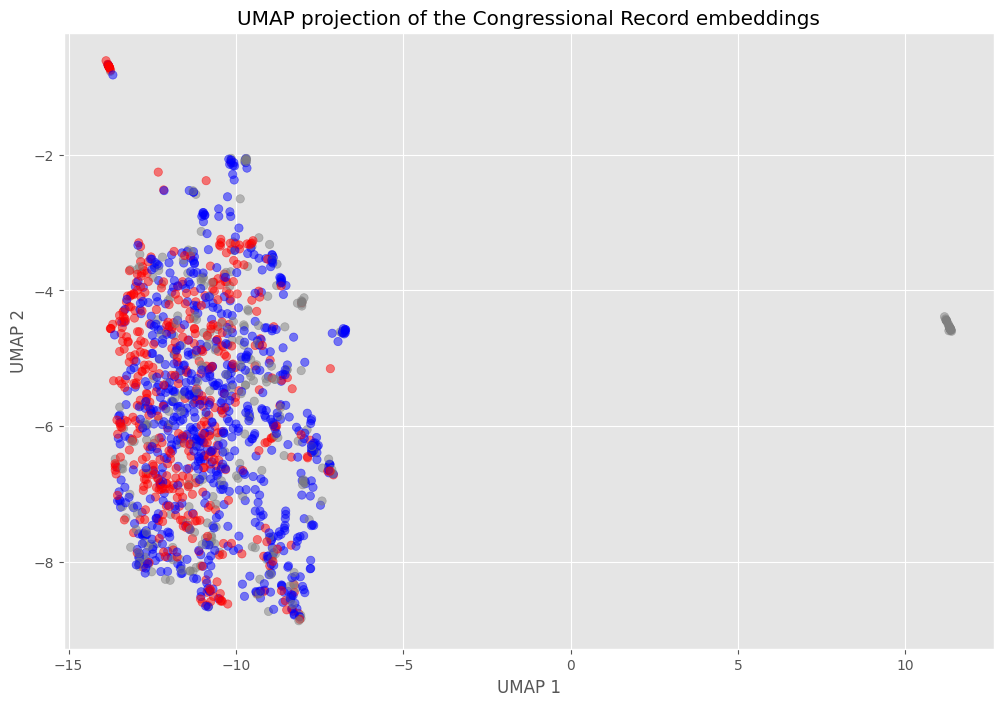

In [142]:
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')

umap_embeddings = umap_model.fit_transform(
    climate_congressional_record_embeddings)

party_colors = {
    'R': 'red',
    'D': 'blue'
}
default_color = 'grey'
colors = climate_congressional_record['party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('UMAP projection of the Congressional Record embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

**Visualising the UK embeddings by party**


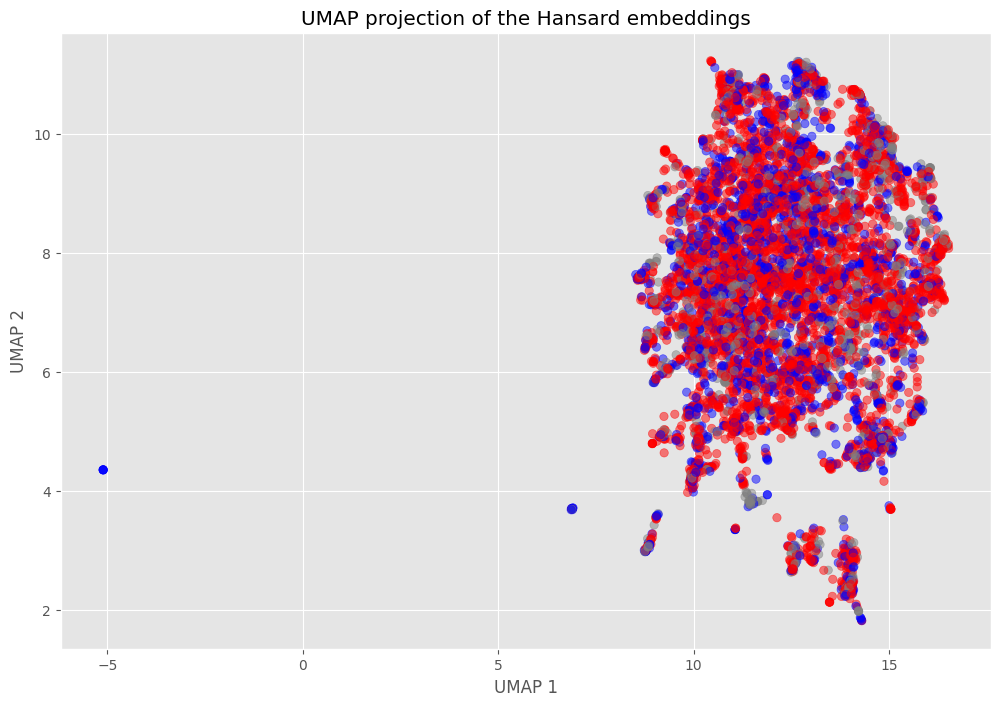

In [143]:
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

umap_embeddings = umap_model.fit_transform(climate_hansard_embeddings)

party_colors = {
    'Conservative': 'blue',
    'Labour': 'red'
}
default_color = 'grey'
colors = climate_hansard['speech_party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('UMAP projection of the Hansard embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

**Comparing the UK and US embeddings**


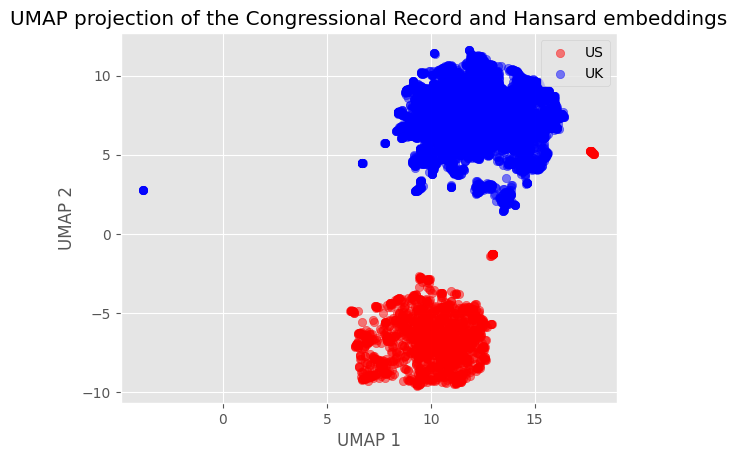

In [144]:
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

umap_congressional_record_embeddings = umap_model.fit_transform(
    climate_congressional_record_embeddings)
umap_hansard_embeddings = umap_model.fit_transform(climate_hansard_embeddings)

plt.scatter(umap_congressional_record_embeddings[:, 0],
            umap_congressional_record_embeddings[:, 1], alpha=0.5, c='red', label='US')
plt.scatter(umap_hansard_embeddings[:, 0],
            umap_hansard_embeddings[:, 1], alpha=0.5, c='blue', label='UK')
plt.title('UMAP projection of the Congressional Record and Hansard embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

**Comparing the UK Labour and the US Democratic embeddings**


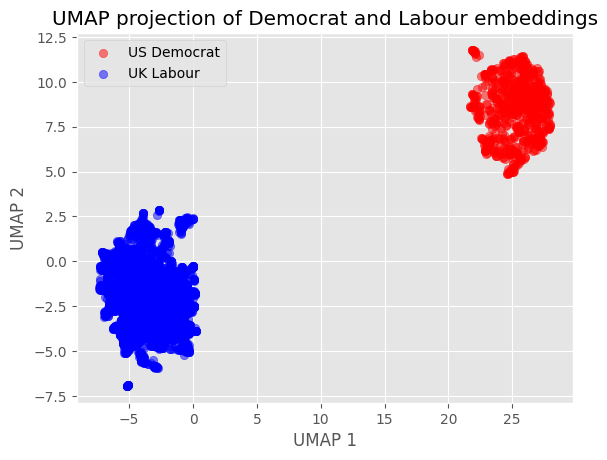

In [145]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

us_democrat_mask = (climate_congressional_record['party'] == 'D')
uk_labour_mask = (climate_hansard['speech_party'] == 'Labour')

climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

us_democrat_embeddings = climate_congressional_record_embeddings[us_democrat_mask]
uk_labour_embeddings = climate_hansard_embeddings[uk_labour_mask]

umap_us_democrat_embeddings = umap_model.fit_transform(us_democrat_embeddings)
umap_uk_labour_embeddings = umap_model.fit_transform(uk_labour_embeddings)

plt.scatter(umap_us_democrat_embeddings[:, 0],
            umap_us_democrat_embeddings[:, 1], alpha=0.5, c='red', label='US Democrat')
plt.scatter(umap_uk_labour_embeddings[:, 0],
            umap_uk_labour_embeddings[:, 1], alpha=0.5, c='blue', label='UK Labour')
plt.title('UMAP projection of Democrat and Labour embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

**Comparing the UK Conservative and the US Republican embeddings**


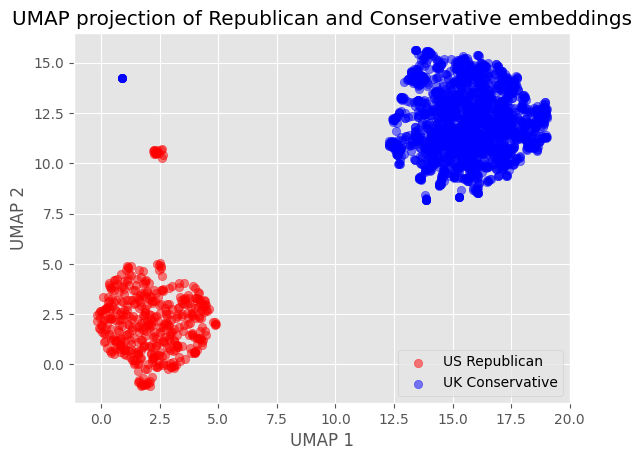

In [146]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

us_republican_mask = (climate_congressional_record['party'] == 'R')
uk_conservative_mask = (climate_hansard['speech_party'] == 'Conservative')

climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

us_republican_embeddings = climate_congressional_record_embeddings[us_republican_mask]
uk_conservative_embeddings = climate_hansard_embeddings[uk_conservative_mask]

umap_us_republican_embeddings = umap_model.fit_transform(
    us_republican_embeddings)
umap_uk_conservative_embeddings = umap_model.fit_transform(
    uk_conservative_embeddings)

plt.scatter(umap_us_republican_embeddings[:, 0],
            umap_us_republican_embeddings[:, 1], alpha=0.5, c='red', label='US Republican')
plt.scatter(umap_uk_conservative_embeddings[:, 0],
            umap_uk_conservative_embeddings[:, 1], alpha=0.5, c='blue', label='UK Conservative')
plt.title('UMAP projection of Republican and Conservative embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

### Visualising the embeddings using PCA


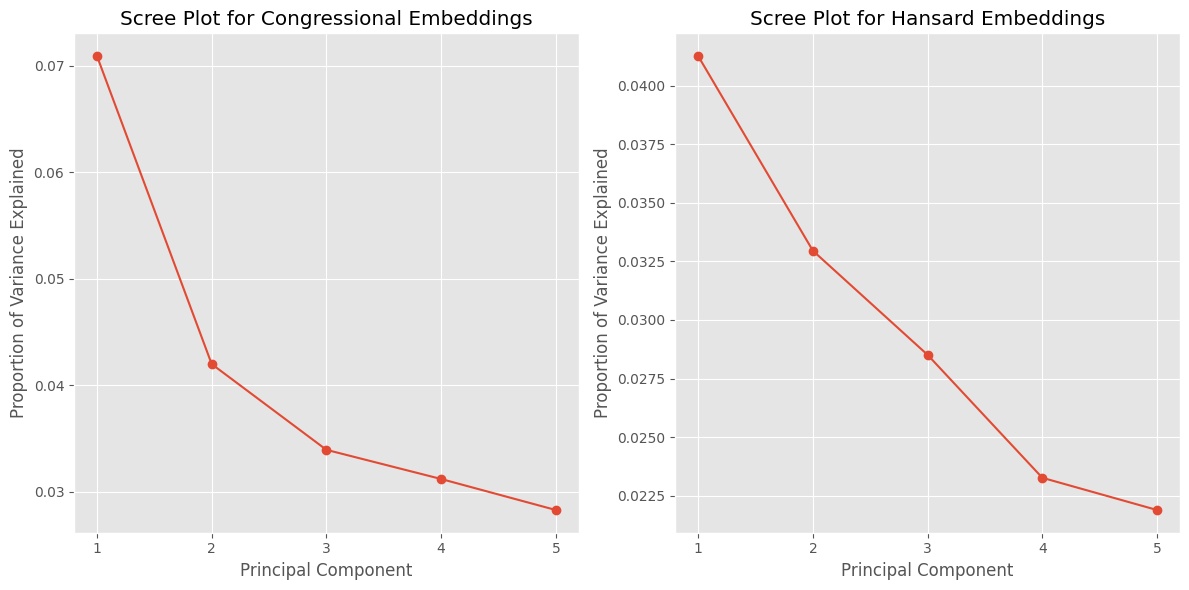

In [147]:
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

pca_congress = PCA()
pca_congress.fit(climate_congressional_record_embeddings)

pca_hansard = PCA()
pca_hansard.fit(climate_hansard_embeddings)

variance_ratios_congress = pca_congress.explained_variance_ratio_
variance_ratios_hansard = pca_hansard.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), variance_ratios_congress[:5], marker='o')
plt.title('Scree Plot for Congressional Embeddings')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, 6))

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), variance_ratios_hansard[:5], marker='o')
plt.title('Scree Plot for Hansard Embeddings')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, 6))

plt.tight_layout()
plt.show()

**Visualising the US embeddings by party**


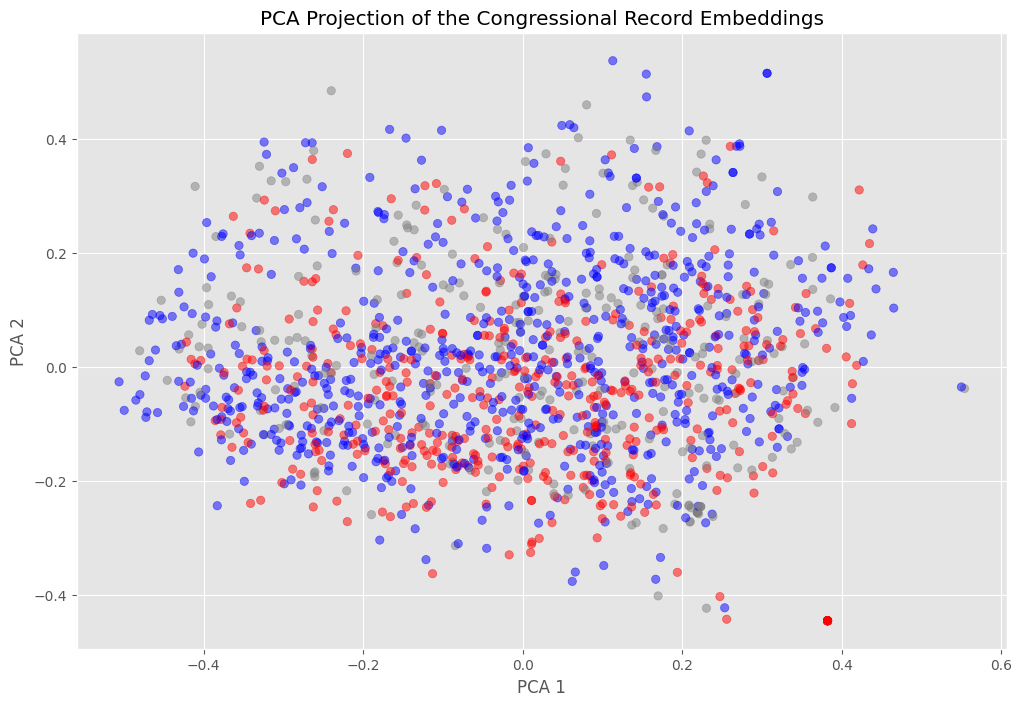

In [148]:
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')

pca_full = PCA()
pca_full.fit(climate_congressional_record_embeddings)
pca_embeddings = pca_full.transform(
    climate_congressional_record_embeddings)

party_colors = {'R': 'red', 'D': 'blue'}
default_color = 'grey'
colors = climate_congressional_record['party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('PCA Projection of the Congressional Record Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

**Visualising the UK embeddings by party**


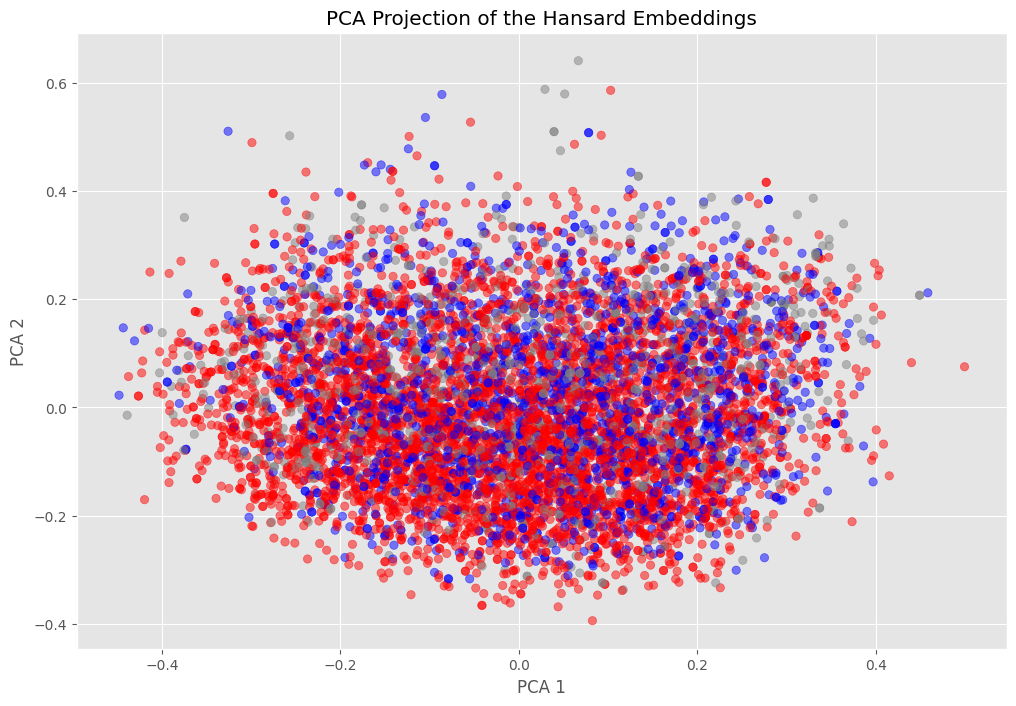

In [149]:
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

pca = PCA()
pca.fit(climate_hansard_embeddings)
pca_embeddings = pca.transform(climate_hansard_embeddings)

party_colors = {
    'Conservative': 'blue',
    'Labour': 'red'
}
default_color = 'grey'
colors = climate_hansard['speech_party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('PCA Projection of the Hansard Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

**Comparing the UK and US embeddings**


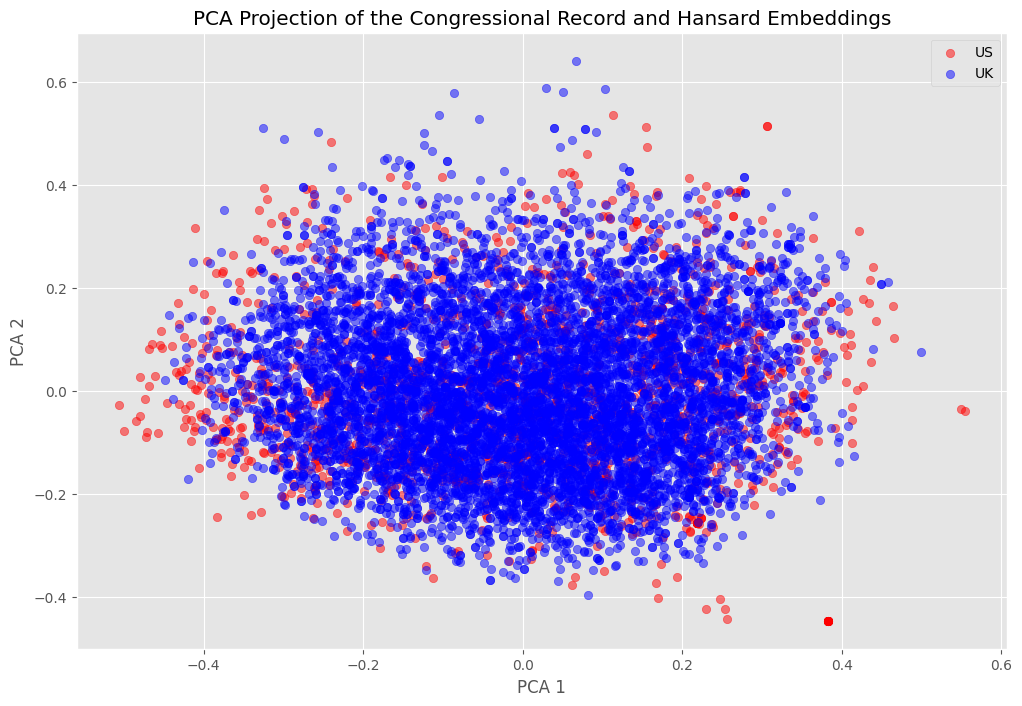

In [150]:
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

pca_congressional_record = PCA()
pca_congressional_record.fit(climate_congressional_record_embeddings)
pca_congressional_record_embeddings = pca_congressional_record.transform(
    climate_congressional_record_embeddings)

pca_hansard = PCA()
pca_hansard.fit(climate_hansard_embeddings)
pca_hansard_embeddings = pca_hansard.transform(
    climate_hansard_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(pca_congressional_record_embeddings[:, 0],
            pca_congressional_record_embeddings[:, 1], alpha=0.5, c='red', label='US')
plt.scatter(pca_hansard_embeddings[:, 0],
            pca_hansard_embeddings[:, 1], alpha=0.5, c='blue', label='UK')
plt.title('PCA Projection of the Congressional Record and Hansard Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

**Comparing the UK Labour and the US Democratic embeddings**


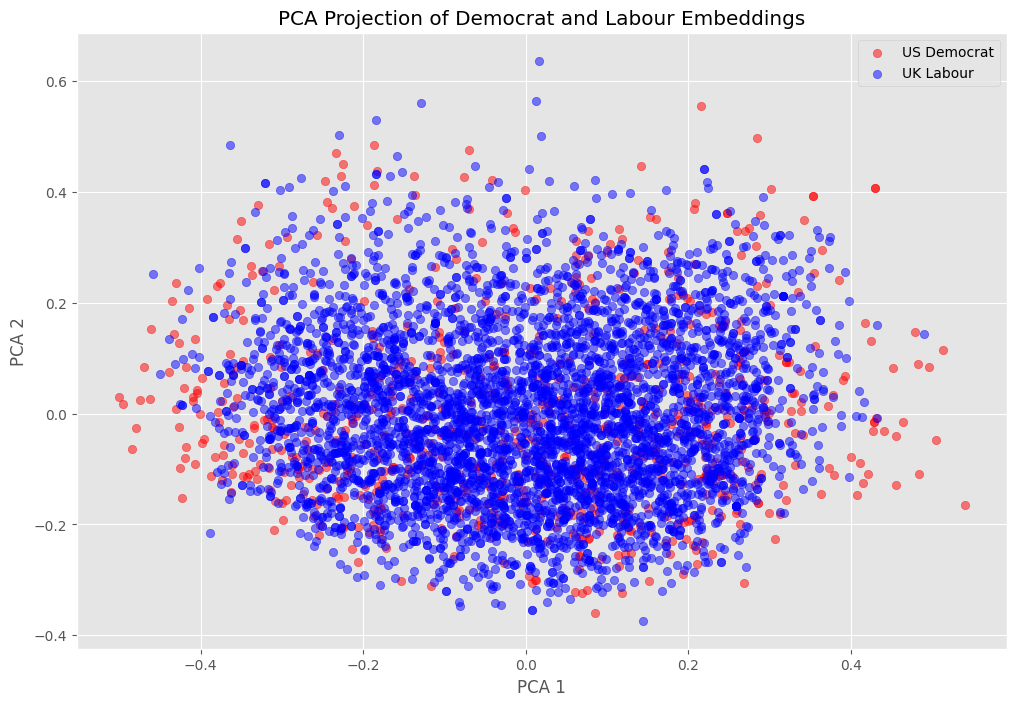

In [151]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

us_democrat_mask = (climate_congressional_record['party'] == 'D')
uk_labour_mask = (climate_hansard['speech_party'] == 'Labour')

climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

us_democrat_embeddings = climate_congressional_record_embeddings[us_democrat_mask]
uk_labour_embeddings = climate_hansard_embeddings[uk_labour_mask]

pca_us_democrat = PCA()
pca_us_democrat.fit(us_democrat_embeddings)
pca_us_democrat_embeddings = pca_us_democrat.transform(us_democrat_embeddings)

pca_uk_labour = PCA()
pca_uk_labour.fit(uk_labour_embeddings)
pca_uk_labour_embeddings = pca_uk_labour.transform(uk_labour_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(pca_us_democrat_embeddings[:, 0],
            pca_us_democrat_embeddings[:, 1], alpha=0.5, c='red', label='US Democrat')
plt.scatter(pca_uk_labour_embeddings[:, 0], pca_uk_labour_embeddings[:,
            1], alpha=0.5, c='blue', label='UK Labour')
plt.title('PCA Projection of Democrat and Labour Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

**Comparing the UK Conservative and the US Republican embeddings**


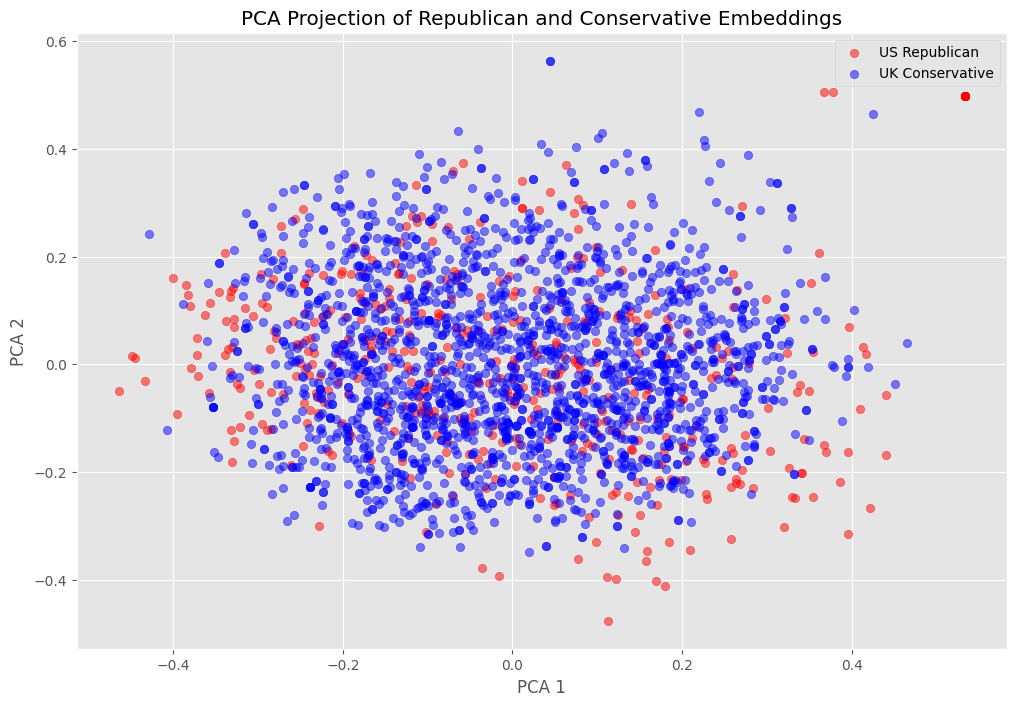

In [152]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

us_republican_mask = (climate_congressional_record['party'] == 'R')
uk_conservative_mask = (climate_hansard['speech_party'] == 'Conservative')

climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

us_republican_embeddings = climate_congressional_record_embeddings[us_republican_mask]
uk_conservative_embeddings = climate_hansard_embeddings[uk_conservative_mask]

pca_us_republican = PCA()
pca_us_republican.fit(us_republican_embeddings)
pca_us_republican_embeddings = pca_us_republican.transform(
    us_republican_embeddings)

pca_uk_conservative = PCA()
pca_uk_conservative.fit(uk_conservative_embeddings)
pca_uk_conservative_embeddings = pca_uk_conservative.transform(
    uk_conservative_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(pca_us_republican_embeddings[:, 0],
            pca_us_republican_embeddings[:, 1], alpha=0.5, c='red', label='US Republican')
plt.scatter(pca_uk_conservative_embeddings[:, 0], pca_uk_conservative_embeddings[:,
            1], alpha=0.5, c='blue', label='UK Conservative')
plt.title('PCA Projection of Republican and Conservative Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

### Plotting the embeddings over time


In [153]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')
climate_congressional_record_embeddings = np.load(
    DATA_PATH + 'climate_congressional_record_embeddings.npy')
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')
climate_hansard_embeddings = np.load(
    DATA_PATH + 'climate_hansard_embeddings.npy')

climate_congressional_record['year_month'] = pd.to_datetime(
    climate_congressional_record['date']).dt.to_period('M')
climate_hansard['year_month'] = pd.to_datetime(
    climate_hansard['speech_date']).dt.to_period('M')


def calculate_period_centroids(speeches_df, time_range, embeddings):
    centroids = {}
    for period in speeches_df[time_range].unique():
        period_speeches = speeches_df[speeches_df[time_range] == period]
        period_embeddings = embeddings[period_speeches.index]
        centroid = period_embeddings.mean(axis=0)
        centroids[period] = centroid
    return centroids


def calculate_cosine_similarities(centroids1, centroids2):
    similarities = {}
    for period in centroids1.index:
        if period in centroids2.index:
            similarity = cosine_similarity(
                [centroids1.loc[period]], [centroids2.loc[period]])[0, 0]
            similarities[period] = similarity
    return similarities

**Calculating various centroids of the Congressional Record and Hansard embeddings over time**


In [154]:
# Calculating the centroids of the Democrat and Republican embeddings over time
democrat_speeches = climate_congressional_record[climate_congressional_record['party']
                                                 == 'D']
republican_speeches = climate_congressional_record[climate_congressional_record['party']
                                                   == 'R']

democrat_centroids = calculate_period_centroids(
    democrat_speeches, 'year_month', climate_congressional_record_embeddings)
republican_centroids = calculate_period_centroids(
    republican_speeches, 'year_month', climate_congressional_record_embeddings)

democrat_centroids = pd.Series(democrat_centroids)
republican_centroids = pd.Series(republican_centroids)

# Calculating the centroids of the Labour and Conservative embeddings over time
labour_speeches = climate_hansard[climate_hansard['speech_party']
                                  == 'Labour']
conservative_speeches = climate_hansard[climate_hansard['speech_party']
                                        == 'Conservative']

labour_centroids = calculate_period_centroids(
    labour_speeches, 'year_month', climate_hansard_embeddings)
conservative_centroids = calculate_period_centroids(
    conservative_speeches, 'year_month', climate_hansard_embeddings)

labour_centroids = pd.Series(labour_centroids)
conservative_centroids = pd.Series(conservative_centroids)

# Calculating the centroids of the US and UK embeddings over time
congressional_record_centroids = calculate_period_centroids(
    climate_congressional_record, 'year_month', climate_congressional_record_embeddings)
hansard_centroids = calculate_period_centroids(
    climate_hansard, 'year_month', climate_hansard_embeddings)

congressional_record_centroids = pd.Series(congressional_record_centroids)
hansard_centroids = pd.Series(hansard_centroids)

**Creating a dataframe of centroid cosine similarities over time**


In [155]:
all_dates = pd.date_range(
    start=climate_congressional_record['year_month'].min().to_timestamp(),
    end=climate_congressional_record['year_month'].max().to_timestamp(),
    freq='MS'
)
all_dates = all_dates.to_period('M')

cosine_similarities_df = pd.DataFrame(index=all_dates)

# Congressional Record and Hansard cosine similarities
cosine_similarities = calculate_cosine_similarities(
    congressional_record_centroids, hansard_centroids)
con_han_similarity_df = pd.DataFrame({
    'year_month': list(cosine_similarities.keys()),
    'con_han_similarity': list(cosine_similarities.values())
})
cosine_similarities_df = cosine_similarities_df.join(
    con_han_similarity_df.set_index('year_month'), how='left')

# Democrat and Republican cosine similarities
cosine_similarities = calculate_cosine_similarities(
    democrat_centroids, republican_centroids)
dem_rep_similarity_df = pd.DataFrame({
    'year_month': list(cosine_similarities.keys()),
    'dem_rep_similarity': list(cosine_similarities.values())
})
cosine_similarities_df = cosine_similarities_df.join(
    dem_rep_similarity_df.set_index('year_month'), how='left')

# Labour and Conservative cosine similarities
cosine_similarities = calculate_cosine_similarities(
    labour_centroids, conservative_centroids)
lab_con_similarity_df = pd.DataFrame({
    'year_month': list(cosine_similarities.keys()),
    'lab_con_similarity': list(cosine_similarities.values())
})
cosine_similarities_df = cosine_similarities_df.join(
    lab_con_similarity_df.set_index('year_month'), how='left')

# Democrat and Labour cosine similarities
cosine_similarities = calculate_cosine_similarities(
    democrat_centroids, labour_centroids)
dem_lab_similarity_df = pd.DataFrame({
    'year_month': list(cosine_similarities.keys()),
    'dem_lab_similarity': list(cosine_similarities.values())
})
cosine_similarities_df = cosine_similarities_df.join(
    dem_lab_similarity_df.set_index('year_month'), how='left')

# Republican and Conservative cosine similarities
cosine_similarities = calculate_cosine_similarities(
    republican_centroids, conservative_centroids)
rep_con_similarity_df = pd.DataFrame({
    'year_month': list(cosine_similarities.keys()),
    'rep_con_similarity': list(cosine_similarities.values())
})
cosine_similarities_df = cosine_similarities_df.join(
    rep_con_similarity_df.set_index('year_month'), how='left')

cosine_similarities_df = cosine_similarities_df.fillna(method='ffill')

/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_1750/1616456117.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cosine_similarities_df = cosine_similarities_df.fillna(method='ffill')


**Plotting the cosine similarity between the Democratic and Republican centroids and the Labour and Conservative centroids over time**


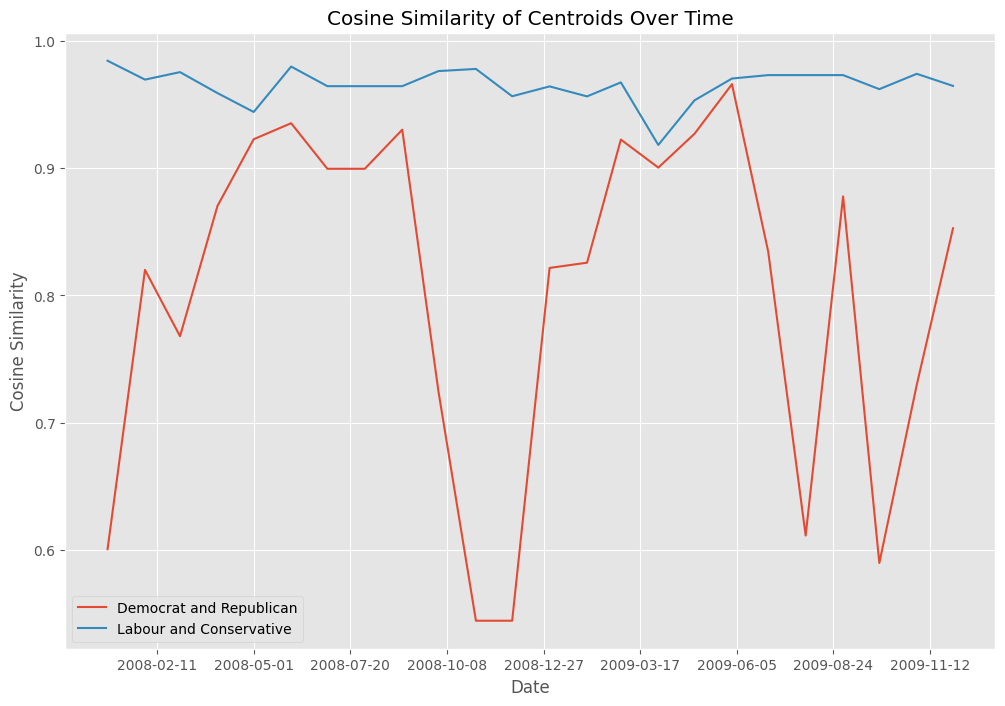

In [156]:
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current Axes instance on the current figure
plt.plot(cosine_similarities_df.index.to_timestamp(),
         cosine_similarities_df['dem_rep_similarity'], label='Democrat and Republican')
plt.plot(cosine_similarities_df.index.to_timestamp(),
         cosine_similarities_df['lab_con_similarity'], label='Labour and Conservative')
# Set the number of ticks on the x-axis to 10
ax.xaxis.set_major_locator(MaxNLocator(10))
plt.title('Cosine Similarity of Centroids Over Time')
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()

plt.show()

**Plotting the cosine similarity between the US and UK centroids, the Democratic and Labour centroids, and the Republican and Conservative centroids over time**


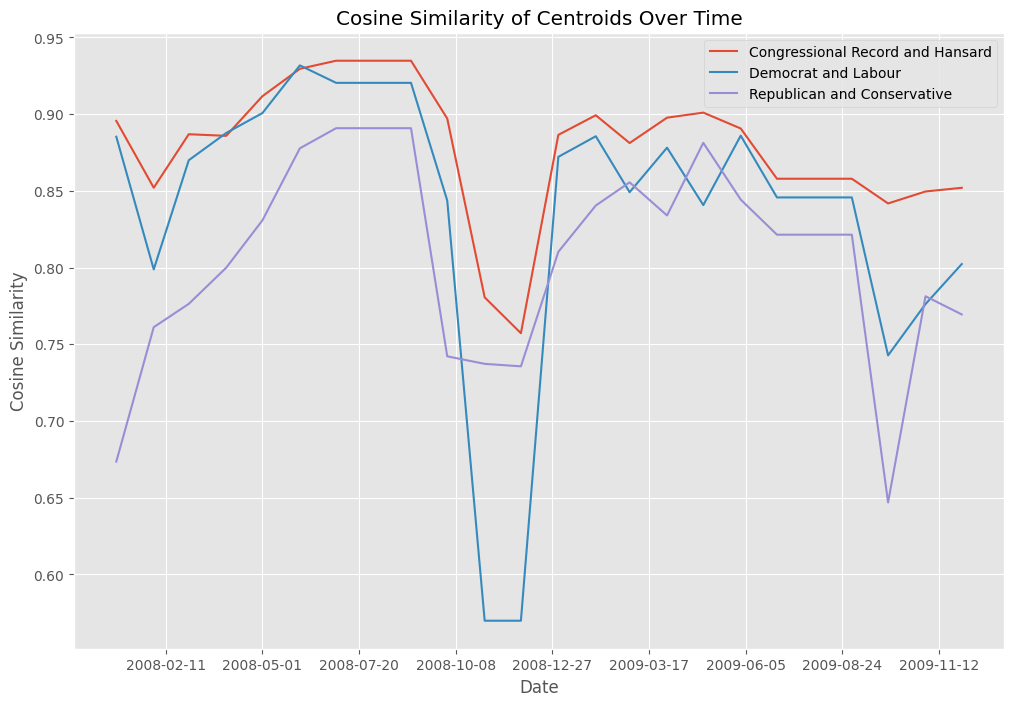

In [157]:
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current Axes instance on the current figure
plt.plot(cosine_similarities_df.index.to_timestamp(),
         cosine_similarities_df['con_han_similarity'], label='Congressional Record and Hansard')
plt.plot(cosine_similarities_df.index.to_timestamp(),
         cosine_similarities_df['dem_lab_similarity'], label='Democrat and Labour')
plt.plot(cosine_similarities_df.index.to_timestamp(),
         cosine_similarities_df['rep_con_similarity'], label='Republican and Conservative')
# Set the number of ticks on the x-axis to 10
ax.xaxis.set_major_locator(MaxNLocator(10))
plt.title('Cosine Similarity of Centroids Over Time')
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()

plt.show()